# Homework 05, group 15




In [2]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# Loading the data

In [3]:
(train_images, train_labels), (test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


# Visualization and shape of the data

image shape:  (50000, 32, 32, 3)
label shape:  (50000, 1)
labels:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 



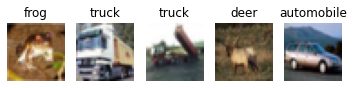

In [4]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print("image shape: ", train_images.shape)
print("label shape: ", train_labels.shape)
print("labels: ", labels, "\n")

fig, ax = plt.subplots(1,5)
for i in range(5):

    # Readout an image and the corresponding label.
    image = train_images[i]
    label = train_labels[i]

    ax[i].imshow(image)
    ax[i].set_title(labels[label[0]])
    ax[i].axis("off")

## Preprocessing

In [5]:
#train data
train_data_images = tf.data.Dataset.from_tensor_slices(train_images)
train_data_images = train_data_images.map(lambda x: tf.cast(x, dtype = tf.float32)/255.0)

train_data_labels = tf.data.Dataset.from_tensor_slices(train_labels.reshape((-1,)))
train_data_labels = train_data_labels.map(lambda x: tf.one_hot(x, 10))

train_data = tf.data.Dataset.zip((train_data_images, train_data_labels))

train_data = train_data.batch(64)
train_data = train_data.shuffle(64)
train_data = train_data.prefetch(16)

#test data
test_data_images = tf.data.Dataset.from_tensor_slices(test_images)
test_data_images = test_data_images.map(lambda x: tf.cast(x, dtype = tf.float32)/255.0)

test_data_labels = tf.data.Dataset.from_tensor_slices(test_labels.reshape((-1,)))
test_data_labels = test_data_labels.map(lambda x: tf.one_hot(x, 10))

test_data = tf.data.Dataset.zip((test_data_images, test_data_labels))

test_data = test_data.batch(64)
test_data = test_data.shuffle(64)
test_data = test_data.prefetch(16)

In [6]:
print(train_data)
print(test_data)

<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.float32)>


# Data Augmentation

In [7]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    brightness_range=(0.5,1.5),
    rotation_range= 40,
)

train_generator = datagen.flow(train_images, train_labels, batch_size=32)

# The Model

In [8]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model):

  def __init__(self):
    super(Model, self).__init__()
    self.hidden_layers = [
                          tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation=None, input_shape=(64,32,32,3), padding='same',  kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Activation('relu'),
                          tf.keras.layers.MaxPool2D(),

                          tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation=None, padding='same',  kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Activation('relu'),
                          tf.keras.layers.MaxPool2D(),

                          tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation=None, padding='same',  kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Activation('relu'),
                          tf.keras.layers.MaxPool2D(),

                          tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation=None, padding='same',  kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Activation('relu'),
                          tf.keras.layers.MaxPool2D(),

                          tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation=None, padding='same',  kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Activation('relu'),
                          tf.keras.layers.MaxPool2D(),

                          tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation=None, padding='same',  kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Activation('relu'),
                          tf.keras.layers.MaxPool2D(),
                          
                          tf.keras.layers.Flatten(),

                          tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                          tf.keras.layers.Dropout(0.2),

                          tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
                          ]

  def call(self, x, training):
        for layer in self.hidden_layers:
          x = layer(x, training=training)
        return x
    

#Training and testing step


In [9]:
def train_step(model, input, target, loss_function, optimizer):
  
  training = True
  #For each batch we compute loss and accuracy based on the models prediction
  with tf.GradientTape() as tape:
    prediction = model(input, training)

    loss = loss_function(prediction, target) + tf.reduce_sum(model.losses)
        
    accuracy = np.sum(np.argmax(target, axis=1) == np.argmax(prediction, axis=1)) / target.shape[0]
    
    #we compute the gradient of the loss with respect to the parameters
    gradients = tape.gradient(loss, model.trainable_variables)
  
  #update the parameters on the basis of the computed gradients
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss, accuracy



def test(model, input, loss_function):

  training = False

  test_losses = []
  test_accuracies = []

  #iterate over the test_data and evaluate the models performance
  for(image,label) in input:
    #prediction of the model for the current samples
    prediction = model(image, training)

    #calculate the loss and accuracy
    loss = loss_function(prediction, label )
    accuracy = (np.argmax(prediction, axis=1) == np.argmax(label, axis = 1))

    test_losses.append(loss.numpy())
    test_accuracies.append(np.mean(accuracy))
  
  #return the mean of the performance data: loss and accuracy
  test_loss = np.mean(test_losses)
  test_accuracy = np.mean(test_accuracies)

  return test_loss, test_accuracy

# Training

In [10]:
tf.keras.backend.clear_session()

#Initialize model
model = Model()

#hyperparameters
epochs = 30
learning_rate = 0.0001


loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)

running_average_factor = 0.95

#To keep track of the processes, we use several lists
training_steps = []

train_losses= []
train_accuracies = []

test_losses = []
test_accuracies = []

#test once before training the model
test_loss, test_accuracy = test(model, test_data, loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#how does the model do on training data before training?
train_loss, train_accuracy = test(model, train_data, loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

#now start to train
#run through the training_data_set in one epoch and adapt parameters (batchwise)
#repeta for number of epochs
for epoch in range(epochs):
  print( "---------------------------------------- Epoch Number:", epoch)

  training_steps.append(epoch)
  #run through the current batch

  train_data = train_data.shuffle(buffer_size=64)
  test_data = test_data.shuffle(buffer_size=64)

  running_average_loss = 0
  running_average_accuracy = 0

  #with a for loop we iterate over all the batches in the datset
  #for each batch in the dataset: peform the training_step and update the parameters based on the computed loss for the whole batch
  for i,(input, label) in enumerate(train_data):
    #to keep track of our models progress we save training loss and accuracy
    training_loss, training_accuracy = train_step(model, input, label, loss, optimizer)

    #however with one 172 batches (thus accuracies and losses) the graph would look quite messy, thus we update our loss and accuracy in a weighted manner
    #after each batch (update is weighted by the running_average_factor)
    running_average_accuracy = running_average_factor * running_average_accuracy + (1- running_average_factor) * training_accuracy
    running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * training_loss 

  #After completing all the batches we append the computed loss and accuracy to the list
  train_losses.append(running_average_loss)
  train_accuracies.append(running_average_accuracy)

  #now evaluate the models performance on test set
  test_loss, test_accur = test(model, test_data, loss)
  
  test_losses.append(test_loss)
  test_accuracies.append(test_accur)

  #print current performance data
  print(i, 'number of test_steps performed: each with 64 examples, so:', 64*i)
  print('training_loss: ', running_average_loss.numpy(), 'training_accuracy: ', train_accuracies[epoch])
  print('test_loss: ', test_loss, 'test_accuracy: ', test_accur)

---------------------------------------- Epoch Number: 0
781 number of test_steps performed: each with 64 examples, so: 49984
training_loss:  17.288963 training_accuracy:  0.10435981457800511
test_loss:  9.7383995 test_accuracy:  0.4069466560509554
---------------------------------------- Epoch Number: 1
781 number of test_steps performed: each with 64 examples, so: 49984
training_loss:  15.140683 training_accuracy:  0.44111234308779146
test_loss:  8.620233 test_accuracy:  0.47302945859872614
---------------------------------------- Epoch Number: 2
781 number of test_steps performed: each with 64 examples, so: 49984
training_loss:  13.715944 training_accuracy:  0.5064529405067989
test_loss:  7.650434 test_accuracy:  0.5307523885350318
---------------------------------------- Epoch Number: 3
781 number of test_steps performed: each with 64 examples, so: 49984
training_loss:  13.052873 training_accuracy:  0.5465685800434259
test_loss:  7.485908 test_accuracy:  0.5399084394904459
--------

# Performance visualization:
## Loss

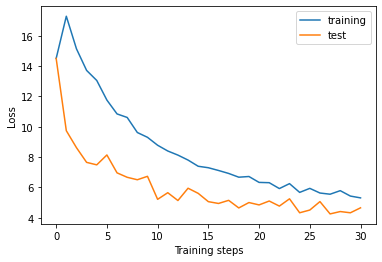

In [11]:
#do the visualization
#test loss and training loss
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

## Accuracy

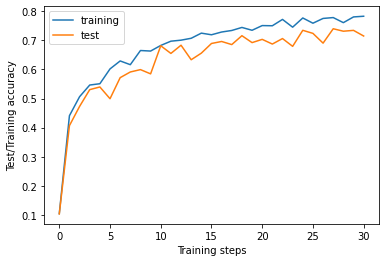

In [12]:
#test accuracy and training accuracy
plt.figure()
line1, = plt.plot(train_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Test/Training accuracy")
plt.legend((line1,line2),("training","test"))
plt.show()